# Classification of Technical Articles

### Group Member Details
***
Devanshika Ghosh - 20196167
Karthik Selvaraj - 20192394
Gokul Nagarajan - 20193832
***
### Dataset Link
https://www.kaggle.com/gspmoreira/articles-sharing-reading-from-cit-deskdrop

### OBJECTIVE : 
The objective of this project is to determine whether or not, a set of articles can be classified or clustered into categories.
### About Dataset:
Deskdrop is a collaboration tool that allows employees to communicate and interact with colleagues by interacting with articles. This dataset comprises of data from the DeskDrop Platform
We have two datasets as follows:

<br><b> 1.	Shared Articles </b>
This dataset contains information about the articles that have been shared on the platform. It has information like the published data, URL of the article, title, content and the language of the article.

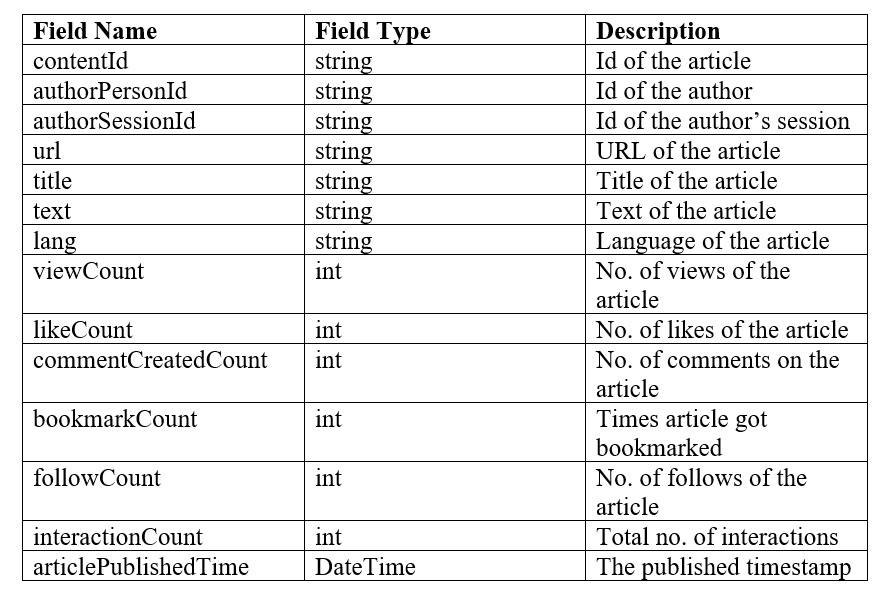

<br><b> 2.	User Interactions</b>
This dataset comprises all logs of the user’s interaction with the article. The information of the user such as users’s country, region, ID and which device they are using to open the article. It also has information about the type of interaction as well.
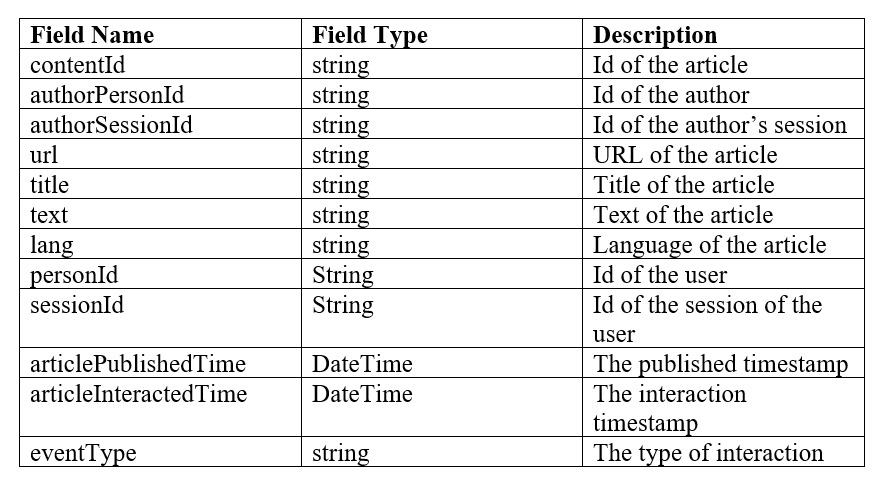
***
<b>Target Variable</b>: CategoryID (for Supervised) and ClusterIndex (for Unsupervised)
<b>Input variables</b>: title, text

In [1]:
# Importing Libraries
import pydot
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.offline as py
import plotly.graph_objects as go
from datetime import datetime
from IPython.display import Image
from IPython.display import display
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora, models, similarities
from sklearn.tree import export_graphviz
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer 
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline 
from sklearn import metrics
import itertools
%matplotlib inline
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix

We have two csv files namely ‘shared_articles.csv’ and ‘user_interactions.csv’. The following codes reads the original datasets :

In [2]:
#Shared Articles Dataset
articlesDF = pd.read_csv(r'C:\Users\devan\Documents\DWorks\CIT Deskdrop data set\shared_articles.csv')
#User Interactions Dataset
interactionsDF = pd.read_csv(r'C:\Users\devan\Documents\DWorks\CIT Deskdrop data set\users_interactions.csv')

### Questions to be answered:

1.How can we classify the articles based on their category? 
 
2.Can we predict the category of the unknown articles with higher precision and accuracy?
    
3.What are the models to be implemented and why are they suitable?

In [3]:
articlesDF.dtypes

timestamp           int64
eventType          object
contentId           int64
authorPersonId      int64
authorSessionId     int64
authorUserAgent    object
authorRegion       object
authorCountry      object
contentType        object
url                object
title              object
text               object
lang               object
dtype: object

In [4]:
interactionsDF.dtypes

timestamp       int64
eventType      object
contentId       int64
personId        int64
sessionId       int64
userAgent      object
userRegion     object
userCountry    object
dtype: object

## Business Understanding:

There are many ways an article classification and clustering model can be used. The below chart explains about how classification and clustering are so effective for the business:

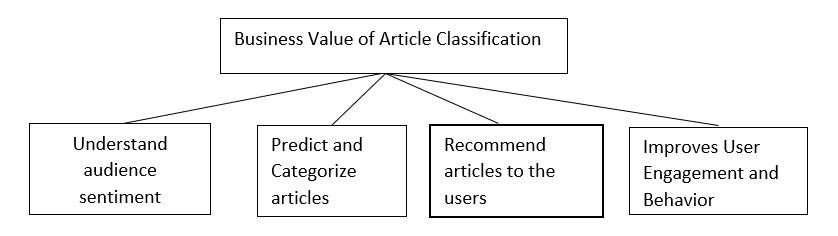

## Data Preparation and Exploratory Data Analysis

### 1.	Correction in Data Types:
Since IDs are in number form, the data was read as type int64 but all the IDs namely, contentId, authorPersonId, authorSessionId, personId, sessionId are of text type so they are converted to string as the first step in data cleaning.

In [5]:
articlesDF.contentId = articlesDF.contentId.astype(str)
articlesDF.authorPersonId = articlesDF.authorPersonId.astype(str)
articlesDF.authorSessionId = articlesDF.authorSessionId.astype(str)
articlesDF.shape

(3122, 13)

In [6]:
interactionsDF.contentId = interactionsDF.contentId.astype(str)
interactionsDF.personId = interactionsDF.personId.astype(str)
interactionsDF.sessionId = interactionsDF.sessionId.astype(str)
interactionsDF.shape

(72312, 8)

### 2.	Deletion of removed articles from the dataframes(CONTENT REMOVED):
There are two types of articles, (‘CONTENT SHARED’,’CONTENT REMOVED’) in the datasets which is explained by the ‘eventType’ column in the Shared article dataset. Since we cannot use removed articles for prediction and categorization, we remove them from both User interactions and Shared article datasets.

In [7]:
# CONTENT REMOVED JUST HAS 75 ENTRIES AND IS CONTENT THAT IS NO LONGER ACCESSIBLE WISE TO DELETE
deletedContentID =articlesDF.contentId[articlesDF.eventType == 'CONTENT REMOVED']
articlesDF = articlesDF[articlesDF.eventType == 'CONTENT SHARED']
articlesDF.drop('eventType', axis=1, inplace=True)
interactionsDF = interactionsDF[~interactionsDF.contentId.isin(deletedContentID)]

### 3.	Renaming column names before merging dataframes:
Since we have timestamp in both dataframe and each timestamp means something different, we rename the timestamp column in dataframes before merging.

In [8]:
#before joining rename similar name columns
articlesDF.rename(inplace = True, columns={"timestamp":"articlePublishedTime"})
interactionsDF.rename(inplace=True, columns={"timestamp": "articleInteractedTime"})

In [9]:
pie_chart = go.Figure()
aLabels = articlesDF['contentType'].value_counts().index
aValues = articlesDF['contentType'].value_counts().values
pie_chart.add_trace(go.Pie(labels=aLabels,values=aValues))
pie_chart.update_traces(textposition='outside', textinfo='percent+label',\
                               marker=dict(colors=['darkorange','gold','red'], line=dict(color='#000000', width=2)))
pie_chart.update_layout(height=500, width=800, title_text="Distributed Type of Content")
pie_chart.show()

#### Observations
- HTML Type is the dominating type of content with almost all articles i.e. 99.3% of the data.
- We can safely remove RICH and VIDEO types since the comprise of a smaller percentage of data

### 4.	Removal of contentType feature from Shared article dataset :
There are articles of three types of content, namely, HTML, RICH, VIDEO. We will remove RICH and VIDEO type since they comprise of a very small percentage of data.

In [10]:
#Delete contents which are not of HTML type and make sure we have the interactions only for those contents which are present
deletedContentID =articlesDF.contentId[articlesDF.contentType != 'HTML']
articlesDF = articlesDF[articlesDF.contentType == 'HTML']
articlesDF.drop('contentType', axis=1, inplace=True)
interactionsDF = interactionsDF[~interactionsDF.contentId.isin(deletedContentID)]

In [11]:
langPie = go.Figure()
aLabels = articlesDF['lang'].value_counts().index
aValues = articlesDF['lang'].value_counts().values
langPie.add_trace(go.Pie(labels=aLabels, values=aValues))
langPie.update_traces(textposition='outside', textinfo='percent+label',\
                               marker=dict(colors=['darkorange','gold','red','yellow','green'], line=dict(color='#000000', width=2)))
langPie.update_layout(height=500, width=800, title_text="Languages of the Distrtibuted Content")
langPie.show()

#### Observations
- The data comprises of mainly two languages i.e. portugal (pt) and english (en)
- Since we plan to classify them, we would only use English articles

### 5.	Cleaned userAgent and authorUserAgent into categories :
UserAgent and authorUserAgent had browser and device information which was used to access the article. To make it easier to see the devices used by the users, we changed them into set categories.

In [12]:
#Create a new column 'authorUserAgentNew' to categorize values for the column 'authorUserAgent' and fill in the missing values
userAgentValues = pd.Series(["Android", "Windows","Linux","Mac","iOS", "NA", "CrOS"], dtype = "category")
articlesDF['authorUserAgent'].fillna("NA",inplace=True)
articlesDF['authorUserAgentNew'] = userAgentValues
for iX, val in userAgentValues.iteritems():
    articlesDF.loc[articlesDF.authorUserAgent.str.contains(val, na=False), 'authorUserAgentNew'] = val
#articlesDF['authorUserAgentNew'].value_counts()
#articlesDF['authorUserAgentNew'].value_counts().sum()
barAuthorAgents = go.Figure()
barAuthorAgents.add_trace(go.Bar(x=articlesDF['authorUserAgentNew'].value_counts().values,y=articlesDF['authorUserAgentNew'].value_counts().index, orientation='h'))
barAuthorAgents.update_layout(height=500, width=800, title_text="Distribution of the Devices used by the Authors")
barAuthorAgents.update_yaxes(categoryorder = 'total ascending')
barAuthorAgents.show()

In [13]:
#Create a new column 'UserAgentNew' to categorize values for the column 'userAgent' and fill in the missing values
interactionsDF['userAgentNew'] = userAgentValues
interactionsDF['userAgent'].fillna("NA",inplace=True)
for iX,val in userAgentValues.iteritems():
    interactionsDF.loc[interactionsDF.userAgent.str.contains(val, na=False), 'userAgentNew'] = val



barUserAgents = go.Figure()
barUserAgents.add_trace(go.Bar(x=interactionsDF['userAgentNew'].value_counts().values,y=interactionsDF['userAgentNew'].value_counts().index,orientation='h'))
barUserAgents.update_layout(height=500, width=800, title_text="Distribution of the Devices used by the Users")
barUserAgents.update_yaxes(categoryorder = 'total ascending')
barUserAgents.show()

#interactionsDF['userAgentNew'].value_counts()
#interactionsDF['authorUserAgentNew'].value_counts().sum()

In [14]:
articlesDF.drop('authorUserAgent', axis=1, inplace=True)
interactionsDF.drop('userAgent', axis=1, inplace=True)
articlesDF.rename(inplace = True, columns={"authorUserAgentNew":"authorUserAgent"})
interactionsDF.rename(inplace = True, columns={"userAgentNew":"userAgent"})

#### Observations
- As you can see that most of the device information isn't available to us
- Therefore, we can disregard these features

### 6.	Interaction eventType to count of categories in articles:
The interaction eventType comprises of all types of interactions that the user did on the articles. The eventTypes are view, like, comment created, bookmark and follow. These were counted from the interactions dataframe and added to the articles dataframe to see the correlation between them.

In [15]:
barInteractionType = go.Figure()
barInteractionType.add_trace(go.Bar(x=interactionsDF['eventType'].value_counts().index,y=interactionsDF['eventType'].value_counts().values))
barInteractionType.update_layout(height=500, width=800, title_text="Interaction type of the Users")
barInteractionType.update_xaxes(categoryorder = 'total descending')
barInteractionType.show()

### Observations
- Most of the articles have interaction as just view and there are a very few percentage of articles that have interactions of other kinds

In [16]:
articlesDF["viewCount"]= 0
articlesDF["likeCount"]=0
articlesDF["commentcreatedCount"]=0
articlesDF["bookmarkCount"]=0
articlesDF["followCount"]=0
articlesDF["interactionCount"]=0

for iX,val in articlesDF.iterrows():
    articlesDF.loc[iX,"viewCount"]=interactionsDF[(interactionsDF.contentId==val.contentId) 
                                                  & (interactionsDF.eventType=="VIEW")].shape[0]
    articlesDF.loc[iX,"followCount"]=interactionsDF[(interactionsDF.contentId==val.contentId) 
                                                    & (interactionsDF.eventType=="FOLLOW")].shape[0]
    articlesDF.loc[iX,"commentcreatedCount"]=interactionsDF[(interactionsDF.contentId==val.contentId) 
                                                            & (interactionsDF.eventType=="COMMENT CREATED")].shape[0]
    articlesDF.loc[iX,"likeCount"]=interactionsDF[(interactionsDF.contentId==val.contentId) 
                                                  & (interactionsDF.eventType=="LIKE")].shape[0]
    articlesDF.loc[iX,"bookmarkCount"]=interactionsDF[(interactionsDF.contentId==val.contentId) 
                                                      & (interactionsDF.eventType=="BOOKMARK")].shape[0]
    articlesDF.loc[iX,"interactionCount"]= interactionsDF[(interactionsDF.contentId==val.contentId)].shape[0]

In [17]:
articlesDF.describe()

articlePublishedTime    viewCount    likeCount  commentcreatedCount  \
count          3.027000e+03  3027.000000  3027.000000          3027.000000   
mean           1.468880e+09    19.959696     1.888999             0.526264   
std            7.583642e+06    27.129692     3.354211             1.279595   
min            1.459194e+09     0.000000     0.000000             0.000000   
25%            1.462413e+09     5.000000     0.000000             0.000000   
50%            1.467201e+09    11.000000     1.000000             0.000000   
75%            1.473968e+09    25.000000     2.000000             0.000000   
max            1.488308e+09   355.000000    53.000000            13.000000   

       bookmarkCount  followCount  interactionCount  
count    3027.000000  3027.000000       3027.000000  
mean        0.809052     0.460852         23.644863  
std         2.217639     1.069327         32.379479  
min         0.000000     0.000000          0.000000  
25%         0.000000     0.000000          5.000000  
50%         0.000000     0.000000         14.000000  
75%         1.000000     0.500000         30.000000  
max        78.000000    14.000000        433.000000

### 7. Visualizing Correlation among all interactions with HeatMap
Correlation among all the interactions are visualized using heatmap as follows: 

In [18]:
numericalColumnNames=["articlePublishedTime", "viewCount","likeCount","commentcreatedCount", "bookmarkCount", "followCount", "interactionCount"]
corrMatrix=articlesDF.corr()
fig = go.Figure(go.Heatmap(x=numericalColumnNames,y=numericalColumnNames,z= corrMatrix,colorscale='YlorRd'))
fig.update_layout(title='Corelation Among Interactions', \
                  width=100 * len(numericalColumnNames), \
                  height=100 * len(numericalColumnNames))
fig.show()

### Observations
- The above heatmap shows correlations between the counts like viewcount and likecount , followcount and commentcreatedcount
- Interactioncount is correlated with everyone since its the total

### 8. EDA on country code:
In the dataset we have only country codes like 'BR' and 'US' which we are changing it into keys and values or names such as 'BRA', 'Brazil' and 'USA', 'United States'. Finally visualized the country as choropleth map using country names and interaction count.

In [19]:
articlesDF.isnull().sum()

articlePublishedTime       0
contentId                  0
authorPersonId             0
authorSessionId            0
authorRegion            2360
authorCountry           2360
url                        0
title                      0
text                       0
lang                       0
authorUserAgent            0
viewCount                  0
likeCount                  0
commentcreatedCount        0
bookmarkCount              0
followCount                0
interactionCount           0
dtype: int64

In [20]:
interactionsDF.isnull().sum()

articleInteractedTime        0
eventType                    0
contentId                    0
personId                     0
sessionId                    0
userRegion               15231
userCountry              15220
userAgent                    0
dtype: int64

In [21]:
country_code_dict = {
    'BR': ('BRA', 'Brazil'),
    'US': ('USA', 'United States'),
    'KR': ('KOR', 'South Korea'),
    'CA': ('CAN', 'Canada'),
    'JP': ('JPN', 'Japan'),
    'AU': ('AUS', 'Australia'),
    'GB': ('GBR', 'United Kingdom'),
    'DE': ('DEU', 'Germany'),
    'DE': ('DEU', 'Germany'),
    'IE': ('IRL', 'Ireland'),
    'IS': ('ISL', 'Iceland'),
    'SG': ('SGP', 'Singapore'),
    'AR': ('ARG', 'Argentina'),
    'PT': ('PRT', 'Portugal'),
    'IN': ('IND', 'India'),
    'ES': ('ESP', 'Spain'),
    'IT': ('ITA', 'Italy'),
    'MY': ('MYS', 'Malaysia'),
    'CO': ('COL', 'Colombia'),
    'CN': ('CHN', 'China'),
    'CL': ('CHL', 'Chile'),
    'NL': ('NLD', 'Netherlands')
}
interactionsFromCountryDF = pd.DataFrame(interactionsDF['userCountry'])
interactionsFromCountryDF['countryCode'] = interactionsDF['userCountry'].apply(lambda x: country_code_dict[x][0] if x in country_code_dict else None)
interactionsFromCountryDF['countryName'] = interactionsDF['userCountry'].apply(lambda x: country_code_dict[x][1] if x in country_code_dict else None)
interactionsFromCountryDF

userCountry countryCode    countryName
0             NaN        None           None
1              US         USA  United States
2             NaN        None           None
3             NaN        None           None
4             NaN        None           None
...           ...         ...            ...
72307          BR         BRA         Brazil
72308          BR         BRA         Brazil
72309          BR         BRA         Brazil
72310          BR         BRA         Brazil
72311          BR         BRA         Brazil

[71573 rows x 3 columns]

In [22]:
interactions_by_country_df = pd.DataFrame(interactionsFromCountryDF.groupby('countryName').size().sort_values(ascending=False).reset_index())
interactions_by_country_df.columns = ['countryName', 'No. of Interactions']
interactions_by_country_df

countryName  No. of Interactions
0           Brazil                50900
1    United States                 4601
2      South Korea                  239
3           Canada                  217
4            Japan                  142
5        Australia                  137
6   United Kingdom                   22
7          Germany                   19
8          Ireland                   14
9          Iceland                   12
10       Singapore                   11
11       Argentina                    7
12        Portugal                    6
13           India                    3
14           Spain                    3
15           Italy                    2
16        Malaysia                    2
17     Netherlands                    1
18        Colombia                    1
19           China                    1
20           Chile                    1

In [23]:
fig = go.Figure(data=go.Choropleth(
    locations=interactions_by_country_df['countryName'], # Spatial coordinates
    z = interactions_by_country_df['No. of Interactions'], 
    locationmode = 'country names', 
    autocolorscale=True,
    colorbar_title = "No. of Interactions",
))

fig.update_layout(
    title_text = 'Interactions by Country', 
    geo_scope='world', 
)

fig.show()

### Observation
- Most of the data is from Brazil as shown in the above graph
- The region and country data have a lot of null values and cannot be used as a feature in further analysis

### 9. MERGING BOTH DATASETS USER INTERACTION AND SHARED ARTICLES: </h3>

We merged the datasets into "interactionswitharticlesDF" to make analyzing easier in future.

In [24]:
# Merge 'interactionsDF' with 'articlesDF'and drop duplicate tuples
interactionswitharticlesDF = pd.merge(interactionsDF, articlesDF, how='inner', on='contentId')
interactionswitharticlesDF = pd.DataFrame(interactionswitharticlesDF[interactionswitharticlesDF['lang'] == 'en'])
interactionswitharticlesDF.drop_duplicates()

articleInteractedTime eventType             contentId  \
0                 1465413032      VIEW  -3499919498720038879   
1                 1465413046      VIEW  -3499919498720038879   
2                 1465907360      VIEW  -3499919498720038879   
3                 1465583412      VIEW  -3499919498720038879   
4                 1465582468      VIEW  -3499919498720038879   
...                      ...       ...                   ...   
71564             1482951829      VIEW   8057379878708189245   
71565             1483007295      VIEW   8057379878708189245   
71566             1482510235      VIEW   7029834616968294970   
71568             1482929120      VIEW  -7108012586837980940   
71569             1483616272      VIEW   7526977287801930517   

                   personId             sessionId userRegion userCountry  \
0      -8845298781299428018   1264196770339959068        NaN         NaN   
1      -8845298781299428018   1264196770339959068         SP          BR   
2       -108842214936804958  -2163423831651021975         SP          BR   
3      -1443636648652872475  -3976301106281818872         SP          BR   
4      -1443636648652872475  -3976301106281818872         SP          BR   
...                     ...                   ...        ...         ...   
71564   8785971928543012853   8714595590796310647         SP          BR   
71565   3761892846624989548   7687596359036798986         SP          BR   
71566   3094513233385472738   1563742406902490761         MG          BR   
71568  -4028919343899978105   1103146045123415934         SP          BR   
71569  -3643155458357242906   8781579964260038140         MG          BR   

      userAgent  articlePublishedTime        authorPersonId  ...  \
0            NA            1465309434  -1032019229384696495  ...   
1           Mac            1465309434  -1032019229384696495  ...   
2       Windows            1465309434  -1032019229384696495  ...   
3         Linux            1465309434  -1032019229384696495  ...   
4         Linux            1465309434  -1032019229384696495  ...   
...         ...                   ...                   ...  ...   
71564   Windows            1482951676   3609194402293569455  ...   
71565       Mac            1482951676   3609194402293569455  ...   
71566   Windows            1466074402  -2979881261169775358  ...   
71568   Windows            1482929117  -4028919343899978105  ...   
71569       Mac            1483616270  -3643155458357242906  ...   

                                                   title  \
0          Hiri wants to fix the workplace email problem   
1          Hiri wants to fix the workplace email problem   
2          Hiri wants to fix the workplace email problem   
3          Hiri wants to fix the workplace email problem   
4          Hiri wants to fix the workplace email problem   
...                                                  ...   
71564  Oculus acquires eye-tracking startup The Eye T...   
71565  Oculus acquires eye-tracking startup The Eye T...   
71566                     Copyrighting DNA Is a Bad Idea   
71568  The Ultimate Digital Clean-Up Checklist: Are Y...   
71569                            Renewing Medium's focus   

                                                    text lang authorUserAgent  \
0      Hiri is the latest startup trying to fix email...   en              NA   
1      Hiri is the latest startup trying to fix email...   en              NA   
2      Hiri is the latest startup trying to fix email...   en              NA   
3      Hiri is the latest startup trying to fix email...   en              NA   
4      Hiri is the latest startup trying to fix email...   en              NA   
...                                                  ...  ...             ...   
71564  The direction you look could one day control y...   en           Linux   
71565  The direction you look could one day control y...   en           Linux   
71566  A few years ago, molecular biologists Jennifer...  

### 10.  Finding distinct articles, user and user sessions:

In [25]:
print('Distinct Articles: \t%d' % len(interactionswitharticlesDF['contentId'].unique()))
print('Distinct Users: \t%d' % len(interactionswitharticlesDF['personId'].unique()))
print('Distinct User sessions: \t%d' % len(interactionswitharticlesDF['sessionId'].unique()))

#The summary shows that 50% of the users have interacted with atleast 6 articles 
interactionswitharticlesDF.groupby('personId')['contentId'].size().describe()

Distinct Articles: 	2094
Distinct Users: 	1641
Distinct User sessions: 	19106


count    1641.000000
mean       28.421085
std        86.963610
min         1.000000
25%         2.000000
50%         6.000000
75%        21.000000
max      1623.000000
Name: contentId, dtype: float64

### 11. Dropped features and checked for missing values:
The following columns has missing values, all of the features are present with str content and have no impact on the target variable, thus all these columns are dropped and the dataset is checked for missing values.

In [26]:
interactionswitharticlesDF.drop(columns=['userCountry', 'userRegion', 'userAgent', 'authorRegion', 'authorCountry', 'authorUserAgent'], axis=1, inplace=True)

interactionswitharticlesDF.isnull().sum() 

articleInteractedTime    0
eventType                0
contentId                0
personId                 0
sessionId                0
articlePublishedTime     0
authorPersonId           0
authorSessionId          0
url                      0
title                    0
text                     0
lang                     0
viewCount                0
likeCount                0
commentcreatedCount      0
bookmarkCount            0
followCount              0
interactionCount         0
dtype: int64

### 12. Converted timestamp values to datetime
The timestamp column in the dataset has been converted into their appropriate date and time format to visualize user interaction and shared articles over time.

In [27]:
def to_datetime(ts):
    return datetime.fromtimestamp(ts)

def to_datetime_str(ts):
    return to_datetime(ts).strftime('%Y-%m-%d %H:%M:%S')

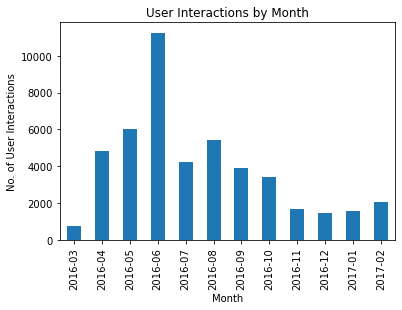

In [28]:
interactionswitharticlesDF['articleInteractedTime'] = interactionswitharticlesDF['articleInteractedTime'].apply(lambda x: to_datetime(x))
interactionswitharticlesDF['month_x'] = interactionswitharticlesDF['articleInteractedTime'].apply(lambda x: '{0}-{1:02}'.format(x.year, x.month))
ploted = interactionswitharticlesDF.groupby('month_x').size().plot(kind='bar', title='User Interactions by Month')
interactionswitharticlesDF.drop('month_x', axis=1, inplace=True)
ploted.set_xlabel('Month')
ploted.set_ylabel('No. of User Interactions')
ploted

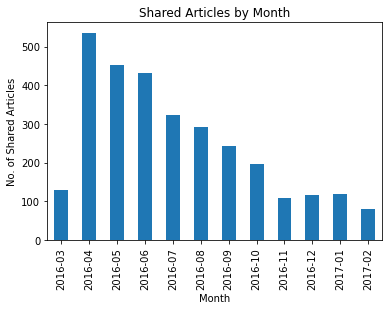

In [29]:
articlesDF['articlePublishedTime'] = articlesDF['articlePublishedTime'].apply(lambda y: to_datetime(y))
interactionswitharticlesDF['articlePublishedTime'] = interactionswitharticlesDF['articlePublishedTime'].apply(lambda y: to_datetime(y))
articlesDF['month_y'] = articlesDF['articlePublishedTime'].apply(lambda y: '{0}-{1:02}'.format(y.year, y.month))
ploted = articlesDF.groupby('month_y').size().plot(kind='bar', title='Shared Articles by Month')
articlesDF.drop('month_y', axis=1, inplace=True)
ploted.set_xlabel('Month')
ploted.set_ylabel('No. of Shared Articles')
ploted

### 13.Main Domains on Shared Articles
Domains of the article are seperated

In [30]:
urlDomainsDF = pd.DataFrame(interactionswitharticlesDF['url'])
urlDomainsDF['urlDomain'] = interactionswitharticlesDF['url'].apply(lambda x: re.sub(r'^http[s]*:\/\/', '', re.search(r'^http[s]*:\/\/[\w\.]*', x, re.IGNORECASE).group(0)))
urlDomainsDF[['urlDomain','url']]

urlDomain  \
0                techcrunch.com   
1                techcrunch.com   
2                techcrunch.com   
3                techcrunch.com   
4                techcrunch.com   
...                         ...   
71564            techcrunch.com   
71565            techcrunch.com   
71566                 nautil.us   
71568  www.smashingmagazine.com   
71569           blog.medium.com   

                                                     url  
0                 http://techcrunch.com/2016/06/07/hiri/  
1                 http://techcrunch.com/2016/06/07/hiri/  
2                 http://techcrunch.com/2016/06/07/hiri/  
3                 http://techcrunch.com/2016/06/07/hiri/  
4                 http://techcrunch.com/2016/06/07/hiri/  
...                                                  ...  
71564  https://techcrunch.com/2016/12/28/the-eye-trib...  
71565  https://techcrunch.com/2016/12/28/the-eye-trib...  
71566  http://nautil.us/blog/copyrighting-dna-is-a-ba...  
71568  https://www.smashingmagazine.com/2016/12/digit...  
71569  https://blog.medium.com/renewing-mediums-focus...  

[46639 rows x 2 columns]

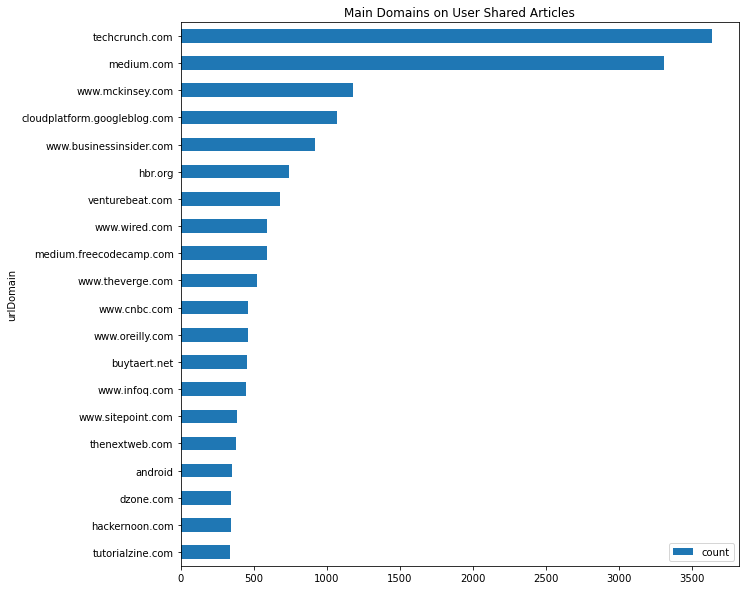

In [31]:
main_domains_df = pd.DataFrame(urlDomainsDF.groupby('urlDomain').size().sort_values(ascending=True))[-20:].reset_index()
main_domains_df.columns = ['urlDomain','count']
main_domains_df['count']
main_domains_df.plot(kind='barh', x='urlDomain', y='count', figsize=(10,10), title='Main Domains on User Shared Articles')

## Dataset Copy for KMeans
We clean the text and title and store it in a seperate database for KMeans

In [104]:
#take out only english articles
english_articles_df = pd.DataFrame(articlesDF[articlesDF['lang'] == 'en'])
english_articles_df.drop(['authorRegion', 'authorCountry', 'authorUserAgent'], axis=1, inplace=True)

In [105]:
articlescopy_df = english_articles_df.copy()
articlescopy_df['AnalysisText']= articlescopy_df['title']+":"+articlescopy_df['text']
# removing everything except alphabets`
articlescopy_df['CleanText'] = articlescopy_df['AnalysisText'].str.replace("[^a-zA-Z#]", " ")
# removing short words
articlescopy_df['CleanText'] = articlescopy_df['CleanText'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
# make all text lowercase
articlescopy_df['CleanText'] = articlescopy_df['CleanText'].apply(lambda x: x.lower())
articlescopy_df.drop(columns=['AnalysisText'],inplace=True)
articlescopy_df.rename(inplace = True, columns={"CleanText":"AnalysisText"})

## Feature Extraction
Feature extraction is one of stages in the information retrieval system that used to extract the unique feature values of a text document. The process of feature extraction can be done by several methods, one of which is Latent Dirichlet Allocation. Words are modeled by a set of topics and documents are modeled by a set of topics. An example is as follows
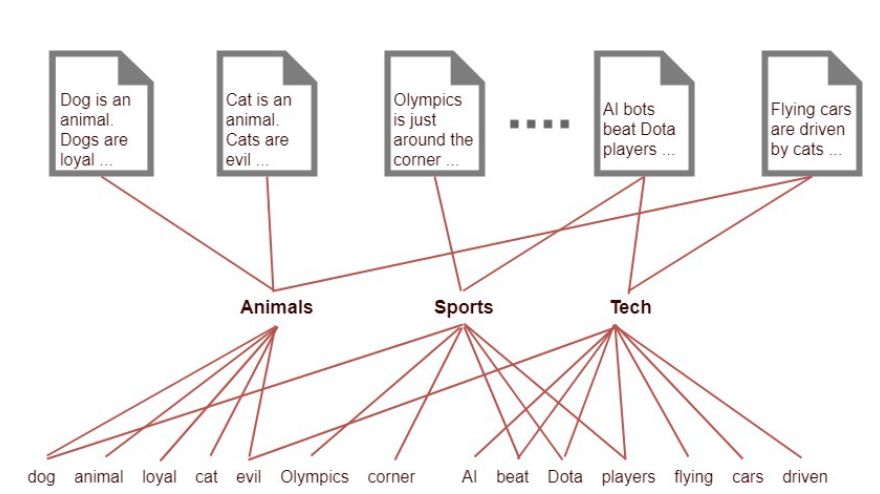

In [106]:
#FeatureExtraction with Latent Dirchlet Allocation
english_articles_content_df = (english_articles_df['title'] + ':' + english_articles_df['text']).tolist()

### Data Pre-Processing for Feature Extraction

1. Tokenization: Split the text into sentences and the sentences into words. Lowercase the words  and remove punctuation.
2. All stopwords are removed.
3. Bigrams (set of two words that occur frequently together) are processed from the unigrams.

In [107]:
#Loading a set of English stopwords
english_stopset = set(stopwords.words('english')).union(
                 {"things", "that's", "something", "take", "don't", "may", "want", "you're", 
                  "set", "might", "says", "including", "lot", "much", "said", "know", 
                  "good", "step", "often", "going", "thing", "things", "think","go", "write", "i'm",
                  "back", "actually", "better", "look", "find", "right", "example",  
                  "verb", "verbs", "really"})

In [108]:
#Tokenizing words of articles
tokenizer = RegexpTokenizer(r"(?u)[\b\#a-zA-Z][\w&-_]+\b")
english_articles_tokens = list(map(lambda d: [token for token in tokenizer.tokenize(d.lower()) if token not in english_stopset], english_articles_content_df))

In [109]:
#Processing bigrams from unigrams (sets of two words that frequently occur together)
bigram_transformer = models.Phrases(english_articles_tokens)
english_articles_unigrams_bigrams_tokens = list(bigram_transformer[english_articles_tokens])

### Bag of words on the dataset
A dictionary is created which contains the list of unique tokens in the corpus and the creation of the dictionary requires to specify two important parameters.

<h3>[Gensim filter_extremes] :</h3>
no_below - This parameter filters out words which are too rare to be informative. Filter out tokens that appear in less than no_below documents (absolute number)

no_above - This parameter filters out words which are too frequent to be informative. Filter out tokens that appear in more than no_above documents (fraction of total corpus size)

<h3>[Gensim doc2bow] :</h3>
For each document we create a dictionary reporting how many words and how many times those words appear. Each word is assumed to be a tokenized and normalized string (either unicode or utf8-encoded). No further preprocessing is done on the words in document; apply tokenization, stemming etc. before calling this method.


In [110]:
#Creating a dictionary and filtering out too rare and too common tokens
english_dictionary = corpora.Dictionary(english_articles_unigrams_bigrams_tokens)
english_dictionary.filter_extremes(no_below=5, no_above=0.4, keep_n=None)
english_dictionary.compactify()
print(english_dictionary)

Dictionary(16311 unique tokens: ['actual', 'advocates', 'agreed_upon', 'agreements', 'aim']...)


In [111]:
#Processing Bag-of-Words (BoW) for each article
english_articles_bow = [english_dictionary.doc2bow(doc) for doc in english_articles_unigrams_bigrams_tokens]

### Running LDA through Bag of Words :

We are going for 5 categories in the document corpus.
Some of the parameters we will be tweaking are :
1. num_topics is the number of requested latent topics to be extracted from the training corpus.
2. id2word is a mapping from word ids (integers) to words (strings). It is used to determine the vocabulary size, as well as for debugging and topic printing
3. Passes is the number of training passes through the corpus.

In [112]:
#Training the LDA topic model on English articles
lda_model = models.LdaModel(english_articles_bow, id2word=english_dictionary, num_topics=5, passes=10, iterations=500)

In [113]:
#Processing the topics for each article
english_articles_lda = lda_model[english_articles_bow]

In [114]:
# Top 5 Keywords for each Category
topic_top5words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 5]

df_top5words_stacked = pd.DataFrame(topic_top5words, columns=['topic_id', 'words'])
df_top5words = df_top5words_stacked.groupby('topic_id').agg(', '.join)
df_top5words.reset_index(level=0,inplace=True)
df_top5words.columns = ['CategoryID', 'Keywords']
df_top5words

CategoryID                                           Keywords
0           0  companies, technology, company, customers, dig...
1           1     drupal, application, developers, services, api
2           2            team, project, software, users, product
3           3     google, machine_learning, ai, search, research
4           4                     code, java, app, event, method

### Defining Categories
Categories inferred using the keywords in each category and their corresponding weights (Category Classification)
0: Software Development
1: Programming
2: Companies 
3: Machine Learning
4: Information Technology

In [115]:
for idX, topic in lda_model.print_topics(-1):
    print("Category: {} \nWords: {}".format(idX, topic))
    print("\n")

Category: 0 
Words: 0.005*"companies" + 0.004*"technology" + 0.004*"company" + 0.004*"customers" + 0.004*"digital" + 0.003*"business" + 0.003*"platform" + 0.003*"customer" + 0.003*"mobile" + 0.002*"product"


Category: 1 
Words: 0.006*"drupal" + 0.005*"application" + 0.004*"developers" + 0.004*"services" + 0.004*"api" + 0.004*"support" + 0.004*"build" + 0.004*"run" + 0.004*"applications" + 0.003*"service"


Category: 2 
Words: 0.010*"team" + 0.004*"project" + 0.004*"software" + 0.004*"users" + 0.003*"product" + 0.003*"teams" + 0.003*"change" + 0.003*"build" + 0.003*"content" + 0.003*"start"


Category: 3 
Words: 0.015*"google" + 0.007*"machine_learning" + 0.007*"ai" + 0.004*"search" + 0.004*"research" + 0.004*"technology" + 0.004*"cloud" + 0.003*"google's" + 0.003*"php" + 0.003*"microsoft"


Category: 4 
Words: 0.012*"code" + 0.006*"java" + 0.006*"app" + 0.006*"event" + 0.005*"method" + 0.004*"page" + 0.004*"list" + 0.004*"create" + 0.004*"events" + 0.004*"image"




### Adding Target Feature to the Current Dataset

Target Feature 'categoryID' has been added to the dataset for all the interactions with articles with their respective percent contribution & keywords

In [116]:
def format_topics_sentences(ldamodel=None, corpus=english_articles_bow, texts=english_articles_unigrams_bigrams_tokens):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the CategoryID, Percent Contribution and Keywords
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([(round(topic_num,0)), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['CategoryID', 'PercentContribution', 'Keywords']

    # Add original text to the end of the output
    return(sent_topics_df)


df_topic_sent_keywords = format_topics_sentences(ldamodel=lda_model, corpus=english_articles_bow, texts=english_articles_unigrams_bigrams_tokens)

# Format
df_topic_sent_keywords.reset_index(drop=True, inplace=True)
english_articles_df.reset_index(drop=True, inplace=True)
english_articles_df = pd.concat([english_articles_df, df_topic_sent_keywords], axis = 1)

In [117]:
english_articles_df

articlePublishedTime             contentId        authorPersonId  \
0     2016-03-28 15:39:48  -4110354420726924665   4340306774493623681   
1     2016-03-28 15:42:26  -7292285110016212249   4340306774493623681   
2     2016-03-28 15:47:54  -6151852268067518688   3891637997717104548   
3     2016-03-28 15:48:17   2448026894306402386   4340306774493623681   
4     2016-03-28 15:48:42  -2826566343807132236   4340306774493623681   
...                   ...                   ...                   ...   
2194  2017-02-24 07:35:56   4675505028897335428  -1393866732742189886   
2195  2017-02-24 09:37:47  -3295913657316686039   6960073744377754728   
2196  2017-02-27 14:20:24   3618271604906293310   1908339160857512799   
2197  2017-02-28 11:51:59   6607431762270322325  -1393866732742189886   
2198  2017-02-28 13:51:11   4109618890343020064   3891637997717104548   

           authorSessionId                                                url  \
0      8940341205206233829  http://www.nytimes.com/2016/03/28/business/dea...   
1      8940341205206233829  http://cointelegraph.com/news/bitcoin-future-w...   
2     -1457532940883382585  https://cloudplatform.googleblog.com/2016/03/G...   
3      8940341205206233829  https://bitcoinmagazine.com/articles/ibm-wants...   
4      8940341205206233829  http://www.coindesk.com/ieee-blockchain-oxford...   
...                    ...                                                ...   
2194  -1729556941184852519  https://medium.mybridge.co/swift-top-10-articl...   
2195  -8193630595542572738  https://thenextweb.com/apps/2017/02/14/amazon-...   
2196   -183341653743161643                        https://code.org/about/2016   
2197   2367029511384577082  https://www.bloomberg.com/news/articles/2017-0...   
2198  -7416795577834806518  https://www.acquia.com/blog/partner/2017-acqui...   

                                                  title  \
0     Ethereum, a Virtual Currency, Enables Transact...   
1     Bitcoin Future: When GBPcoin of Branson Wins O...   
2                          Google Data Center 360° Tour   
3     IBM Wants to "Evolve the Internet" With Blockc...   
4     IEEE to Talk Blockchain at Cloud Computing Oxf...   
...                                                 ...   
2194   Swift Top 10 Articles For The Past Year (v.2017)   
2195  Amazon takes on Skype and GoToMeeting with its...   
2196                        Code.org 2016 Annual Report   
2197  JPMorgan Software Does in Seconds What Took La...   
2198               The 2017 Acquia Partners of the Year   

                                                   text lang  viewCount  \
0     All of this work is still very early. The firs...   en          1   
1     The alarm clock wakes me at 8:00 with stream o...   en          1   
2     We're excited to share the Google Data Center ...   en         10   
3     The Aite Group projects the blockchain market ...   en          0   
4     One of the largest and oldest organizations fo...   en          2   
...                                                 ...  ...        ...   
2194  For the past year , we've ranked nearly 9,000 ...   en          9   
2195  Amazon has launched Chime, a video conferencin...   en          3   
2196  February 9, 2017 - We begin each year with a l...   en          1   
2197  At JPMorgan Chase & Co., a learning machine is...   en          1   
2198  The Acquia Partner Awards Program is comprised...   en          2   

      likeCount  commentcreatedCount  bookmarkCount  followCount  \
0             0                    0              0            0   
1             0                    0              0            0   
2             3                    0              0            0   
3             0                    0              0            0   
4             0                    0              0            0   
...         ...                  ...            ...          ...   
2194          3                    1              2            2   
2

### Visualizing the Distribution of Categories

In [118]:
english_articles_df.CategoryID = english_articles_df.CategoryID.astype(int)

In [119]:
english_articles_df["CategoryID"].value_counts()

0    632
3    493
2    487
1    397
4    190
Name: CategoryID, dtype: int64

In [120]:
temp_df = english_articles_df.groupby(['CategoryID', 'Keywords']).size().reset_index(name='Freq')
temp_df

CategoryID                                           Keywords  Freq
0           0  companies, technology, company, customers, dig...   632
1           1  drupal, application, developers, services, api...   397
2           2  team, project, software, users, product, teams...   487
3           3  google, machine_learning, ai, search, research...   493
4           4  code, java, app, event, method, page, list, cr...   190

In [121]:
Category = ["","", "","", ""]
for i,row in temp_df.iterrows():
    listKeywrds = row['Keywords'].split(",")
    listKeywrds = listKeywrds[0:3]
    Category[row['CategoryID']] = ", ".join(listKeywrds)
Category

['companies,  technology,  company',
 'drupal,  application,  developers',
 'team,  project,  software',
 'google,  machine_learning,  ai',
 'code,  java,  app']

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001FCA100AFD0>],
      dtype=object)

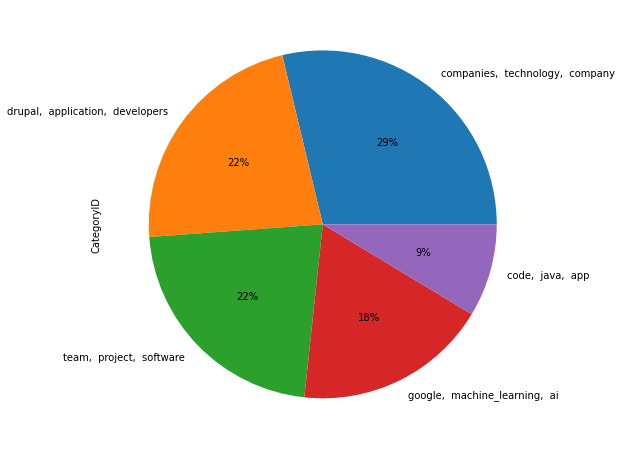

In [122]:
english_articles_df["CategoryID"].value_counts().plot(kind='pie', labels=Category, autopct='%1.0f%%', subplots=True, figsize=(8, 8))

## Models

### K Means Clustering
Since the original dataset had no categories and class labels, we decided to implement unsupervised learning in our model

In [123]:
vectorizer = TfidfVectorizer(stop_words='english',max_df = 0.5, smooth_idf=True)
X = vectorizer.fit_transform(articlescopy_df['AnalysisText'])

In [124]:
kmeans_model=KMeans(n_clusters=56)
kmeans_model.fit(X)

KMeans(n_clusters=56)

In [125]:
Y=kmeans_model.predict(X)

In [126]:
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, kmeans_model.labels_, sample_size=1000))

Silhouette Coefficient: 0.019


Because the Silhouette Coefficient is very low, KMeans algorithm cannot be used to cluster unseen data, hence we try another model for the same

### Logistic Regression
As we have used LDA to do semantic analysis and find categories of the data, we can use a supervised learning aglorithm like Logistic Regression.

In [127]:
X = english_articles_df['text'] + "  " + english_articles_df['title']
y = english_articles_df['CategoryID']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [128]:
#Calculating the number of rows in our train set
len(y_train)

1539

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001FCBA56CEE0>],
      dtype=object)

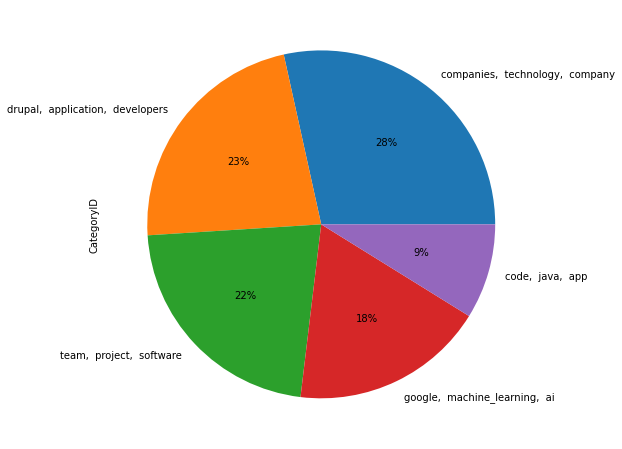

In [129]:
y_train.value_counts().plot(kind='pie', labels=Category, autopct='%1.0f%%', subplots=True, figsize=(8, 8))

### Training the Logistic Regression Classifier

In order to train and test the classifier, the first step should be to tokenize and count the number of occurrence of each word that appear in the articles.

We use the CountVectorizer() for that. Each term is assigned a unique integer index.

Then the counters are transformed to a TF-IDF representation using TfidfTransformer().

The last step creates the Logistic Regression classifier. It is worth noting that the default mode for the LogisticRegression() function can only help us classify binary target variables. In order to be able to classify a multi-class problem, we specify multi_class=’multinomial’. Also worth noting is that the only solvers that can be used for a multiclass problem are: newton-cg, sag & lbfgs which are specified using the solver=newton_cg parameter in the LogisticRegression() function.

In order to make the training process easier, scikit-learn provides a Pipeline class that behaves like a compound classifier.

In [130]:
text_np = Pipeline([('vect', CountVectorizer()),
                         ('tfidf', TfidfTransformer()),
                         ('clf2', LogisticRegression(solver='newton-cg', multi_class='multinomial')),
                         ])

In [131]:
text_np = text_np.fit(X_train, y_train)
predicted2 = text_np.predict(X_test)

In [132]:
metrics.accuracy_score(y_test, predicted2)

0.793939393939394

In [133]:
print(metrics.classification_report(y_test, predicted2, target_names=sorted(Category)))

                                   precision    recall  f1-score   support

                code,  java,  app       0.79      0.87      0.83       194
 companies,  technology,  company       0.80      0.87      0.83       119
drupal,  application,  developers       0.77      0.73      0.75       147
   google,  machine_learning,  ai       0.79      0.82      0.81       146
        team,  project,  software       0.93      0.46      0.62        54

                         accuracy                           0.79       660
                        macro avg       0.82      0.75      0.77       660
                     weighted avg       0.80      0.79      0.79       660



In [134]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

In [135]:
cnf_matrix = confusion_matrix(y_test, predicted2)

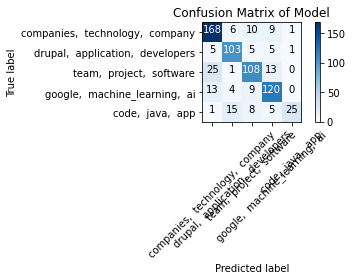

In [136]:
plt.figure()
plot_confusion_matrix(cnf_matrix,classes=Category,title='Confusion Matrix of Model')

We can see from the metrics that the precision an f1-score are really good for our trained model.

The overall accuracy of classification is 79.39%

## Conclusion
***
Only useful feature for document classification is the text and title of the article. NLP is used since models don't understand text data. Once the input is inline with the models, we decided which model to use. KMeans is used since our dataset is not labeled. But since KMeans isn't providing good results (Silhouette Coefficient of 0.019), we moved on to supervised classification i.e. Logistic Regression. 

This algorithm was chosen as it allows multinomial classification and proper solver was chosen according to the problem. We used NLP to get the labels. The algorithm showed good accuracy (79.39%) and precision, recall and f1-score are also in high standing. This proves that logistic regression can be clearly used for classifying documents into categories. 

In [141]:
unseen_text_data = ['Google has worked hard on machine learning. They have researched a lot and provided machine learning frameworks and models for all kinds of devices. With their ML Kit for mobile, they have made machine learning disconnected with main servers. This means that now user data will be safe from artificial intelligence (ai).']
predicted_unseen = text_np.predict(unseen_text_data)
Category[predicted_unseen[0]]

'google,  machine_learning,  ai'

In [142]:
unseen_text_data = ['Lets do programming in Java. This application programming interface allows for vast options. You can program for Android. You can do iOS programming. Any kind of platform can use JAVA programmed applications since it is platform independant. That is the beauty of this object oriented programming language.']
predicted_unseen = text_np.predict(unseen_text_data)
Category[predicted_unseen[0]]

'code,  java,  app'

In [143]:
unseen_text_data = ['Google has decided to make their company governed by the parent company of Alphabet. Larry Page has made Sundar Pichai as the CEO of the search engine giant and retained control over many companies that are owned and operated under Alphabet. This is a very smart move since it allows the company to purchase assets without a lot of repurcursions of the tech industry.']
predicted_unseen = text_np.predict(unseen_text_data)
Category[predicted_unseen[0]]

'companies,  technology,  company'

As you can see from above, our model performs well with unseen data as well